In [1]:
import os
import sys
from pathlib import Path

import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)


from src.utils import IATAProcessor
processor = IATAProcessor(custom_stopwords=["iata", "aviation", "air", "industry", "iatas", "airlines", "aircraft", "billion", "million", "travel"])

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

c:\Users\kruu\git_folder\iata_recommendation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kruu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kruu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


****
# Topic Extraction
****

Processing tasks:
- Extract text from pdf
- Chunk text into group of sentences (default 5) using sent_tokenize
- Clean chunks by converting to lowercases, removing ponctuation and stopwords

Embedding:
- Using HugginFace MiniLM-L6-v2

Topic Modeling:
- Use BERTopic
- First dimensionality reduction using UMAP
- Then HDBSCAN for clustering chunks with similar semantics
- Finaly TF-IDF to rank keywords that represent each topic
- Using vectorizer in BERTopi to specify how to turn the clean text into a bag-of-words representation for keyword representation.

In [ ]:
data_dir = Path("../data")
pdf_files = sorted(data_dir.glob("iata-annual-review-*.pdf"))

yearly_topic_data = []

for pdf in pdf_files:
    year_match = re.search(r"(\d{4})", pdf.stem)
    if not year_match:
        continue
    year = int(year_match.group(1))

    print(f"Processing {pdf.name} for year {year}")
    cleaned_chunks = processor.preprocess_pdf(pdf, chunk_size=5)
    embeddings = embedding_model.encode(cleaned_chunks, show_progress_bar=True)

    vectorizer = CountVectorizer(stop_words=list(processor.stopwords))
    topic_model = BERTopic(vectorizer_model=vectorizer, verbose=False)
    topics, _ = topic_model.fit_transform(cleaned_chunks, embeddings)
    
    topic_keywords = {
        topic_id: ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
        for topic_id in set(topics)
        if topic_id != -1  # exclude outlier topic
    }

    df = pd.DataFrame({
        "year": [year] * len(cleaned_chunks),
        "chunk": cleaned_chunks,
        "topic": topics
    })
    
    print(f"Proportion of unassigned chunks: {len(df[df.topic == -1]) / len(cleaned_chunks)}", end = "\n\n")
    
    df = df[df.topic != -1]  # Remove outliers

    df["topic_label"] = df["topic"].map(topic_keywords)
    
    yearly_topic_data.append((year, topic_model, df))
  
#Create saving directory    
Path("../artifacts").mkdir(exist_ok=True)
with open("../artifacts/yearly_topic_data.pkl", "wb") as f:
    pickle.dump(yearly_topic_data, f)
print("Saved yearly_topic_data to artifacts/yearly_topic_data.pkl")


In [5]:
from collections import defaultdict, Counter

# year -> Counter of words (with frequency from repeated labels)
yearly_word_counts = defaultdict(Counter)

for year, model, df in yearly_topic_data:
    # Count how many times each topic_label appears
    label_counts = df["topic_label"].value_counts()
    
    for label, count in label_counts.items():
        words = label.lower().split(", ")
        for word in words:
            yearly_word_counts[year][word] += count
            
for year in sorted(yearly_word_counts):
    print(f"{year} — Top Words:")
    for word, count in yearly_word_counts[year].most_common(5):
        print(f"   {word}: {count}", end = "\n")

2005 — Top Words:
   new: 64
   security: 40
   safety: 40
   cargo: 40
   international: 40
2006 — Top Words:
   efficiency: 72
   safety: 70
   security: 70
   cargo: 70
   data: 70
2007 — Top Words:
   fuel: 50
   emissions: 50
   charges: 50
   growth: 50
   years: 50
2008 — Top Words:
   passenger: 141
   safety: 121
   new: 121
   airports: 121
   cargo: 121
2009 — Top Words:
   savings: 90
   fuel: 67
   cargo: 47
   airports: 47
   security: 47
2010 — Top Words:
   safety: 128
   cargo: 128
   airports: 128
   global: 128
   program: 128
2011 — Top Words:
   safety: 140
   security: 140
   program: 140
   global: 140
   airports: 140
2012 — Top Words:
   airline: 174
   global: 153
   safety: 153
   passenger: 153
   security: 153
2013 — Top Words:
   passenger: 134
   fuel: 104
   cargo: 103
   security: 103
   passengers: 103
2014 — Top Words:
   passenger: 110
   cargo: 84
   data: 82
   security: 64
   ndc: 64
2015 — Top Words:
   cargo: 200
   passenger: 200
   safety: 200

****
# Grouping similar Topic ID through semantics
****

Evaluate topic evolution:
- Create embeddings on the previously found topic ids for all years
- Group similar embeddings with Kmeans

In [6]:
encoder = SentenceTransformer("all-MiniLM-L6-v2")

unique_topics = []

for year, model, df in yearly_topic_data:
    for topic_id, label in df[["topic", "topic_label"]].drop_duplicates().values:
        unique_topics.append((year, topic_id, label))

In [7]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

vectors = [encoder.encode(label) for (_, _, label) in unique_topics]
vectors_norm = normalize(vectors, norm='l2')

best_k = None
best_score = -1
best_model = None

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    group_ids = kmeans.fit_predict(vectors_norm)
    score = silhouette_score(vectors_norm, group_ids)
    print(f"k={k}, silhouette_score={score:.3f}")
    
    if score > best_score:
        best_k = k
        best_score = score
        best_model = kmeans

print(f"Best k = {best_k} with silhouette score = {best_score:.3f}")

group_ids = best_model.labels_

Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\kruu\git_folder\iata_recommendation\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>
  File "c:\Users\kruu\git_folder\i

k=2, silhouette_score=0.094
k=3, silhouette_score=0.111
k=4, silhouette_score=0.129
k=5, silhouette_score=0.103
k=6, silhouette_score=0.125
k=7, silhouette_score=0.118
k=8, silhouette_score=0.129
k=9, silhouette_score=0.127
k=10, silhouette_score=0.120
k=11, silhouette_score=0.108
k=12, silhouette_score=0.111
k=13, silhouette_score=0.117
k=14, silhouette_score=0.097
Best k = 8 with silhouette score = 0.129


In [ ]:
# Assigning each topic from BERTopic to a Kmeans cluster
topic_to_meta = {
    (year, topic_id): group_id
    for (year, topic_id, _), group_id in zip(unique_topics, group_ids)
}

meta_topic_df = pd.concat([
    df.assign(group_id=df["topic"].map(lambda tid: topic_to_meta.get((year, tid))))
    for year, model, df in yearly_topic_data
])

# Count per year
evolution = meta_topic_df.groupby(["group_id", "year"]).size().unstack().fillna(0)

In [ ]:
from collections import Counter

# Topic keywords chosen according to the most frequent label per group (entire list of keywords) 
group_keywords = {}

for group_id, group_df in meta_topic_df.groupby("group_id"):
    all_words = []
    for label in group_df["topic_label"]:
        all_words.extend(label.lower().split(", "))
    top_keywords = [word for word, _ in Counter(all_words).most_common(5)]
    group_keywords[group_id] = ", ".join(top_keywords)

group_keywords

{0: 'passenger, cargo, chief, executive, officer',
 1: 'safety, saf, airline, review, annual',
 2: 'growth, markets, passenger, fuel, freight',
 3: 'cargo, security, passenger, global, safety',
 4: 'emissions, fuel, environmental, carbon, charges',
 5: 'safety, iosa, accidents, audit, accident',
 6: 'settlement, ndc, order, passenger, airline',
 7: 'airport, airports, charges, infrastructure, international'}

In [22]:
group_labels = (
    meta_topic_df.groupby("group_id")["topic_label"]
    .agg(lambda x: x.value_counts().index[0])  # Most frequent label per group
    .to_dict()
)
group_labels

{0: 'passenger, ndc, cargo, agents, data, passengers, experience, global, new, order',
 1: 'safety, saf, airport, annual, airline, cargo, review, international, data, emissions',
 2: 'markets, fuel, year, revenues, freight, cash, average, growth, capacity, prerecession',
 3: 'cargo, passenger, safety, global, security, airline, airport, fuel, airports, passengers',
 4: 'fuel, transport, efficiency, tax, airline, emissions, years, costs, global, oil',
 5: 'safety, management, accidents, iosa, cargo, operations, flight, airline, issues, audit',
 6: 'agents, ndc, settlement, order, services, bsp, baggage, airline, payments, passenger',
 7: 'airport, infrastructure, airports, capacity, charges, slot, regulation, investment, regulatory, privatization'}

<Figure size 2000x600 with 0 Axes>

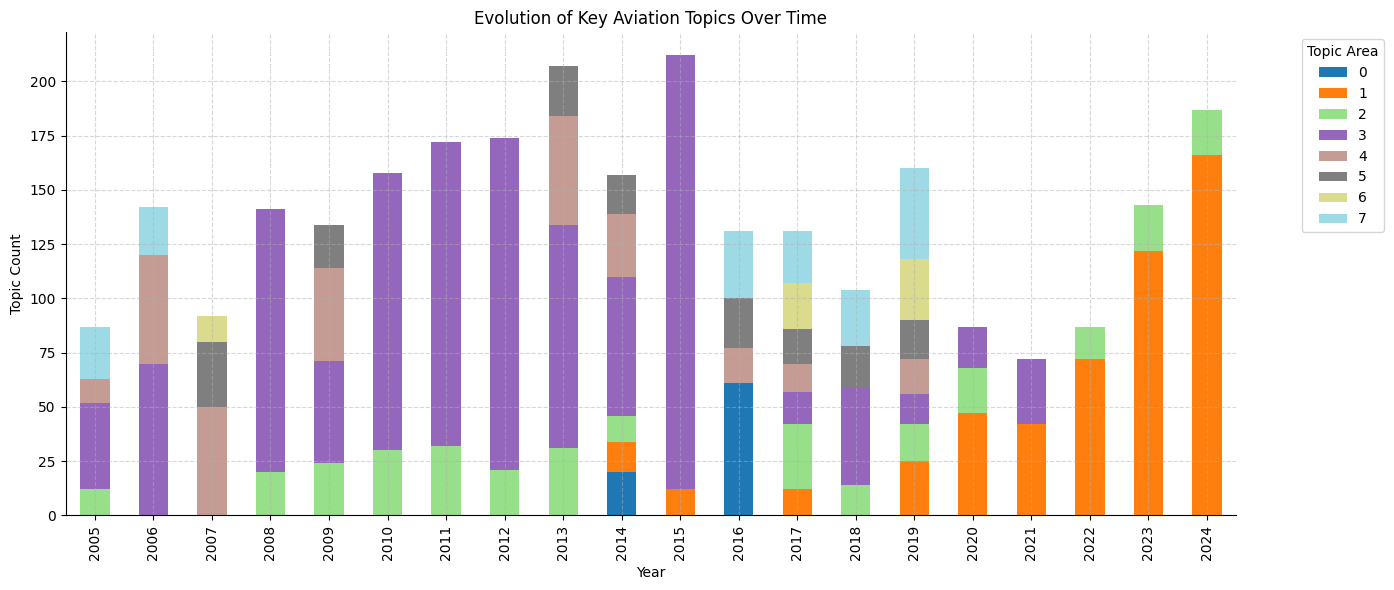

In [ ]:
plt.figure(figsize=(20, 6))
evolution.T.rename(index=group_labels).plot(
    kind="bar", stacked=True, figsize=(14, 6),
    colormap="tab20"
)
plt.title("Evolution of Key Aviation Topics Over Time")
plt.xlabel("Year")
plt.ylabel("Topic Count")
plt.legend(title="Topic Area", bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha = 0.5, linestyle = "--")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

In [13]:
# Detect fastest growing topics
slopes = evolution.apply(lambda x: np.polyfit(evolution.columns, x, 1)[0], axis=1)
print(slopes.sort_values(ascending=False))  # Fastest-growing topics at top

group_id
1    5.754887
6    0.133083
0    0.122556
2    0.118045
7   -0.042857
5   -0.235338
4   -1.657143
3   -4.507519
dtype: float64
